# Introduction

Nama      : Immanuel Yosia Alfrenco

Dataset   : https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

Objective : Hotel merupakan salah satu hal penting dalam liburan. Cepatnya perkembangan zaman membuat lebih banyak cara dalam memilih hotel yang baik salah satunya adalah menggunakan reservasi online dengan aplikasi seperti Trip Advisor. Dataset yang digunakan ini berisi review hotel dengan jumlah sekitar 20 ribu dimana bisa digunakan untuk membantu menentukan mana hotel yang baik mana yang bukan. Dalam kasus ini akan dibuat model untuk membuat sentimen analisis terhadap review hotel di Trip Advisor.


# Import Libraries

In [17]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

import re
import string
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, GRU, Dropout
from tensorflow.keras.models import Model, Sequential

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Loading

In [19]:
# Load Dataset

df = pd.read_csv('https://raw.githubusercontent.com/alfrenco/file_milestone/main/tripadvisor_hotel_reviews.csv')
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [20]:
# Check dataset - 1

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


* Dataset terdiri atas 2 kolom dan 20491 entries dimana 1 kolom bertipe object/string dan 1 lagi bertipe integer/numeric.

In [21]:
# Check dataset - 2

df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


* Rating pada dataset berkisar antara 1 sampai 5 dimana dataset ini memiliki rata-rata rating sebesar 3.9

# Exploratory Data Analysis (EDA)

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64



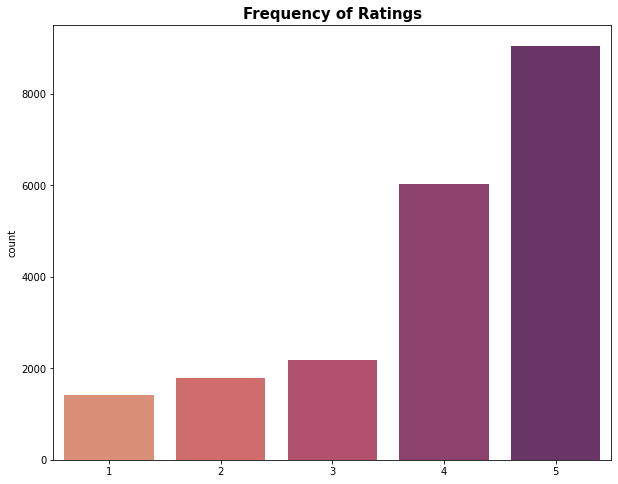

In [22]:
# See the frequency of ratings

print(df['Rating'].value_counts())
print('')

figure(figsize=(10, 8))
sns.countplot(data=df, x='Rating', palette='flare').set_title('Rating Distribution Across Dataset')
plt.title('Frequency of Ratings', weight='bold', fontsize=15)
plt.xlabel('')
plt.show()

* Rating paling banyak adalah rating 5 dengan jumlah rating lebih dari 9000. Lalu rating terbanyak kedua adalah rating 4 dengan jumlah lebih dari 6000 rating.

In [23]:
# Length of word in sentence

df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


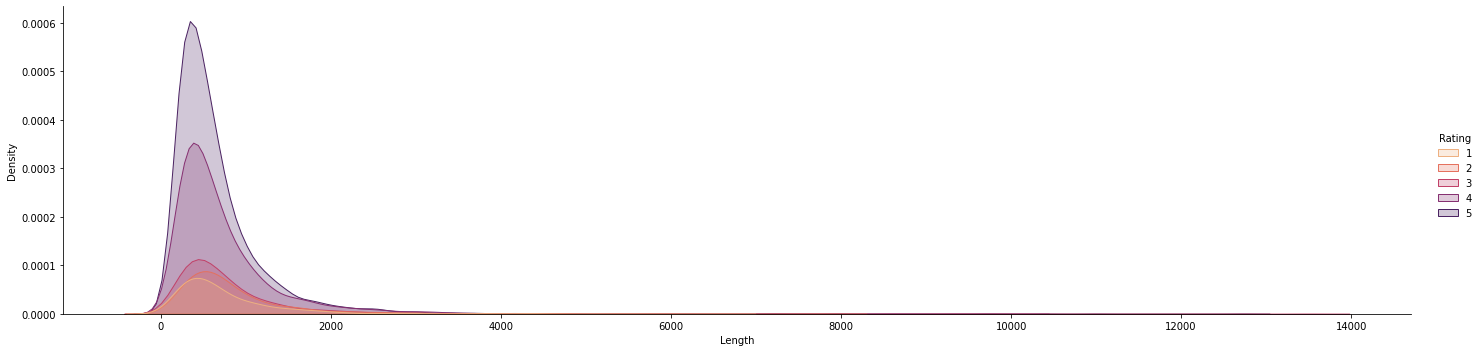

In [24]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

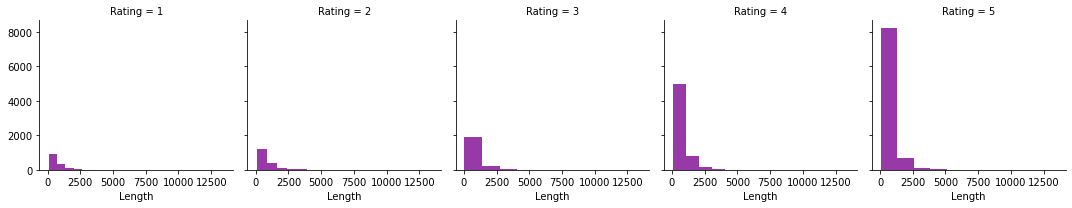

In [25]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

* Plot di atas menunjukan bahwa semakin tinggi peringkat hotel, semakin besar kemungkinan pengunjung menulis ulasan yang panjang.

Selanjutnya, akan dilakukan interpretasi rating menjadi sentimen. Rating dibawah sama dengan tiga menjadi label Bad dan rating diatas tiga menjadi label Good. Sentimen ini yang akan menjadi label untuk model.

In [26]:
# Changing rating into label "Good" and "Bad"

def ratings(rating):
  if rating > 3:
    return "Good"
  else:
    return "Bad"

df['Rating'] = df['Rating'].apply(ratings)

Good    15093
Bad      5398
Name: Rating, dtype: int64



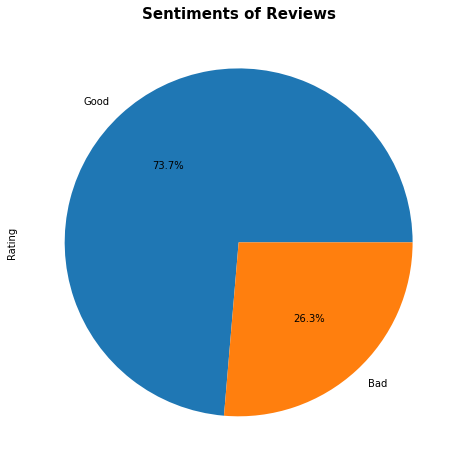

In [27]:
# See value counts of Rating

print(df['Rating'].value_counts())
print('')

df.Rating.value_counts().plot(kind='pie', figsize=(8,8), autopct='%1.1f%%')
plt.title('Sentiments of Reviews', weight='bold', fontsize=15)
plt.show()

* 73.7% Review memiliki sentimen Good, sedangkan 26.3% review lainnya memiliki sentimen Bad.

# Data Preprocessing

## Create Data Inference

In [28]:
# Get Data for Model Inference

df_inf1 = df.sample(10, random_state=7)

df_inf1

,Review,Rating,Length
12927,fabulous sirenis tropical-punta cana march 12-...,Good,822
2538,star prices star product idyllic setting gorge...,Bad,866
16184,great location mong kok great location explori...,Good,210
4868,"perfect london accomodation, thoroughly enjoye...",Good,571
9255,unhelpful unfriendly staff hotel excellent loc...,Bad,436
4001,"overpriced bland, hotel usually stay old san j...",Bad,440
10844,"b stayed weekend boyfriend, room 239 ask savin...",Bad,437
1645,good value money stayed nights excelent locati...,Bad,98
4055,pleasant comfortable business mexico city stay...,Good,344
4560,great hotel choose different location room lov...,Good,254


In [29]:
# Remove Inference Set from Dataset

df_train_test = df.drop(df_inf1.index)

df_train_test

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Bad,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",Good,733
20487,great location price view hotel great quick pl...,Good,306
20488,"ok just looks nice modern outside, desk staff ...",Bad,443
20489,hotel theft ruined vacation hotel opened sept ...,Bad,5557


In [30]:
# Reset Index

df_train_test.reset_index(drop=True, inplace=True)
df_inf1.reset_index(drop=True, inplace=True)

df_inf1

,Review,Rating,Length
0,fabulous sirenis tropical-punta cana march 12-...,Good,822
1,star prices star product idyllic setting gorge...,Bad,866
2,great location mong kok great location explori...,Good,210
3,"perfect london accomodation, thoroughly enjoye...",Good,571
4,unhelpful unfriendly staff hotel excellent loc...,Bad,436
5,"overpriced bland, hotel usually stay old san j...",Bad,440
6,"b stayed weekend boyfriend, room 239 ask savin...",Bad,437
7,good value money stayed nights excelent locati...,Bad,98
8,pleasant comfortable business mexico city stay...,Good,344
9,great hotel choose different location room lov...,Good,254


## Preprocessing Corpus

Beberapa tahapan preprocessing yang dilakukan pada text yaitu:

* Membuat semua teks menjadi lowercase
* Menghilangkan teks dalam bracket
* Memperbaiki contractions. contractions adalah jenis kata unik yang menggabungkan dua atau lebih kata lain dalam bentuk yang dipersingkat, biasanya dengan apostrof. contoh : he's atau I'm menjadi he is atau i am
* Menghilangkan tanda baca
* Menghilangkan angka
* Menghilangkan huruf non-latin
* Menghilangkan non-words
* Menghilangkan whitespace
* Menghilangkan stopwords
* Lemmatization

In [31]:
# Make a function of text preprocessing

def clean_rev(rev):

    # make text lowercase
    rev = rev.lower()

    # remove text in bracket
    rev = re.sub('', '', rev)

    # fix contractions
    rev = contractions.fix(rev)

    # remove punctuation
    rev = re.sub('[%s]' % re.escape(string.punctuation), '', rev)

    # remove words containing numbers
    rev = re.sub('\w*\d\w*', '', rev)

    # remove non-latin words
    rev = re.sub('[^\x00-\x7f]', '', rev)

    # remove non-words (emoji, etc.)
    rev = re.sub("[^A-Za-z\s']", " ", rev)

    # remove underscores
    rev =  str.replace(rev, '_', '')

    # remove whitespace
    rev = rev.strip()

    # Tokenization
    tokens = word_tokenize(rev)

    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    rev = [word for word in tokens if word not in stop_words]
                   
    # Lemmatize the word
    sentence = []
    for word in rev:
      lm = WordNetLemmatizer()
      sentence.append(lm.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [32]:
# Apply function to dataFrame

df_train_test['ReviewCleaned'] = df_train_test['Review'].apply(lambda x: clean_rev(x))
df_train_test['ReviewCleaned']

0        nice hotel expensive park get good deal stay h...
1        ok nothing special charge diamond member hilto...
2        nice room not experience hotel monaco seattle ...
3        unique great stay wonderful time hotel monaco ...
4        great stay great stay go seahawk game awesome ...
                               ...                        
20476    best keep secret time stay charm not ca nt bea...
20477    great location price view hotel great quick pl...
20478    ok look nice modern outside desk staff nt part...
20479    hotel theft ruin vacation hotel open sept gues...
20480    people talk ca nt believe excellent rat hotel ...
Name: ReviewCleaned, Length: 20481, dtype: object

In [33]:
df_train_test.head()

,Review,Rating,Length,ReviewCleaned
0,nice hotel expensive parking got good deal sta...,Good,593,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,Bad,1689,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,Bad,1427,nice room not experience hotel monaco seattle ...
3,"unique, great stay, wonderful time hotel monac...",Good,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",Good,1281,great stay great stay go seahawk game awesome ...


In [34]:
# See the difference before and after preprocessing

print('Document 10: ' , df_train_test.Review[10])
print(' ')
print('Preprocessed Document 10: ' , df_train_test.ReviewCleaned[10])

Document 10:  poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,  
 
Preprocessed Document 10:  poor value stay monaco seattle july nice hotel price night not hotel take beat quotient experience simply average nothing exceptional pay nt ca nt terribly disappoint wife stay nicest suit felt like overpay best advice shop qualitywise league average marriott nice best western


## Splitting between X and y

In [35]:
# Splitting X and y

X = df_train_test['ReviewCleaned']
y = df_train_test['Rating']

## Splitting between Train Set, Validation Set, and Test Set

In [36]:
# Split train-set, val-set, and test-set

X_train_val, X_test, y_train_val, y_test = train_test_split (X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split (X_train_val, y_train_val, test_size=0.15, random_state=42)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)
print('Val Size : ', X_val.shape)

Train Size :  (14796,)
Test Size :  (3073,)
Val Size :  (2612,)


## Label Encoding

Label target akan dilakukan encoding dimana Bad menjadi 0, dan Good menjadi 1.

In [37]:
# Encoding target

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

print(le.classes_)

['Bad' 'Good']


## Tokenization
     

In [38]:
# Get Vocabularies

cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train)
X_val_vec = cv.transform(X_val)
X_test_vec = cv.transform(X_test)

X_train_vec

<14796x55208 sparse matrix of type '<class 'numpy.int64'>'
	with 1132061 stored elements in Compressed Sparse Row format>

In [39]:
# Get number of Vocab and maximum document length

vocabs = len(cv.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah Vocab : ", vocabs)
print("Max Length dari Dokumen : ", max_sen_len, "words")

Jumlah Vocab :  55208
Max Length dari Dokumen :  1865 words


In [40]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=vocabs,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

## Word Embedding

In [41]:
# Embedding

embedding = Embedding(input_dim=vocabs,
                      output_dim=64,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

## Word Cloud

In [42]:
# See Top 10 Token

text_vectorization.get_vocabulary()[:10]

['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good', 'staff']

* Top 10 Token berdasarkan hasil text vectorization adalah hotel, room, not, stay, great, nt, good, staff.

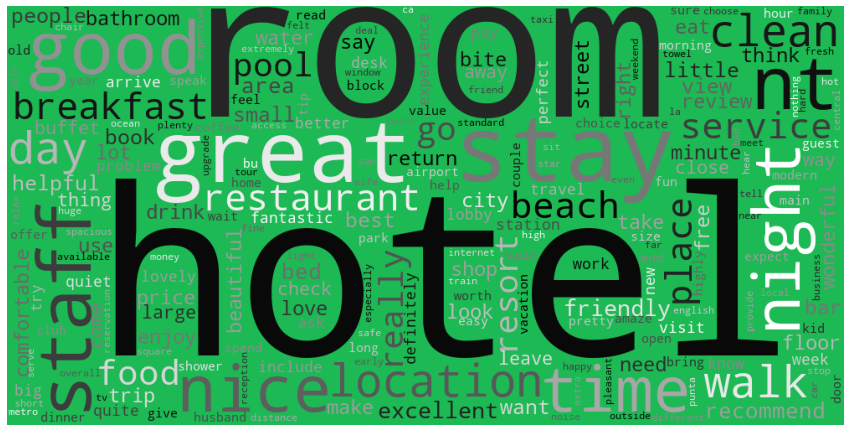

In [43]:
# Wordcloud for good reviews
goodrev = df_train_test[df_train_test['Rating'] == 'Good']['ReviewCleaned']

plt.figure(figsize=(15,15))
wordcloudgood = WordCloud(max_words=1000, min_font_size=10, height=500, width=1000, background_color='#1db954', colormap='gist_yarg', collocations=False).generate(' '.join(goodrev))

plt.axis('off')
plt.imshow(wordcloudgood)

In [44]:
# See top 10 words
goods = pd.DataFrame(wordcloudgood.process_text(''.join(goodrev)).items()).sort_values(1, ascending=False)
    
for i in range(10):
  item = goods.iloc[i]
  print(item[0] + ' \t= ' + str(item[1]))

hotel 	= 37835
room 	= 30512
stay 	= 19497
great 	= 15067
staff 	= 12493
nt 	= 12263
good 	= 11637
night 	= 9323
time 	= 8714
location 	= 8621


* Top 10 words pada Good Review seperti hotel, room, stay, great, staff, good, night, time, dan location.

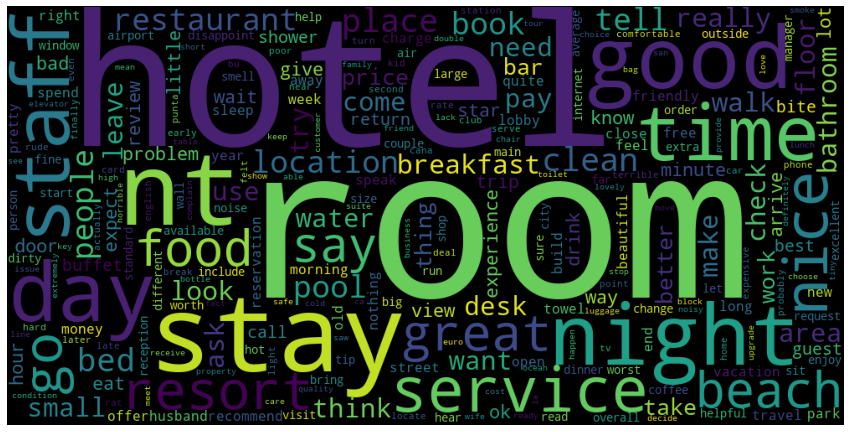

In [45]:
# Wordcloud for bad reviews 
badrev = df_train_test[df_train_test['Rating'] == 'Bad']['ReviewCleaned']

plt.figure(figsize=(15,15))
wordcloudbad = WordCloud(max_words=1000, min_font_size=10, height=500, width=1000, background_color='Black', collocations=False).generate(' '.join(badrev))

plt.axis('off')
plt.imshow(wordcloudbad)

In [46]:
# See top 10 words
bads = pd.DataFrame(wordcloudgood.process_text(''.join(badrev)).items()).sort_values(1, ascending=False)
    
for i in range(10):
  item = bads.iloc[i]
  print(item[0] + ' \t= ' + str(item[1]))
     

room 	= 15609
hotel 	= 13642
stay 	= 6913
nt 	= 6464
night 	= 4296
good 	= 4245
day 	= 4143
staff 	= 3730
time 	= 3619
service 	= 3316


* Top 10 words pada Bad Review seperti hotel, room, stay, staff, good, night, time, day, dan service.
* Yang menjadi pembeda Good dan Bad adalah pada Bad Review banyak terdapat kata service. Kemungkinan banyak orang yang merasa servicenya kurang bagus.

# Model Definition

In [47]:
# Creating the Model

#Optimizer
optimizer = Adam(lr=0.0001)

model = Sequential()

model.add(text_vectorization)
model.add(embedding)
model.add(Dropout(0.50))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15)))
model.add(Dropout(0.50))
model.add(Dense(15, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))

# compile
model.compile(loss='binary_crossentropy', 
                         optimizer=optimizer,
                         metrics= 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1865)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1865, 64)          3533312   
                                                                 
 dropout (Dropout)           (None, 1865, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 30)               9600      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 15)                4

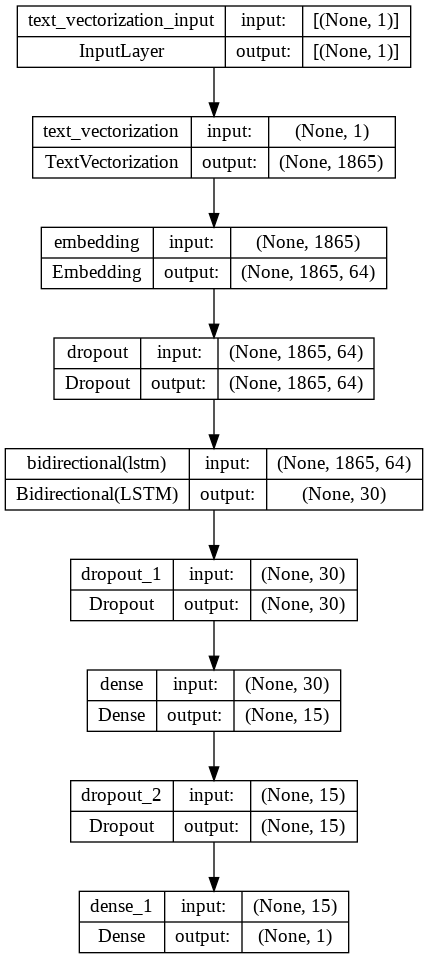

In [48]:
# plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

Model ini memiliki beberapa layer utama yaitu input layer, TextVectorization layer, Embedding layer, Bidirectional LSTM layer, dense layer, dan output layer.
* Layer TextVectorization dan Embedding adalah layer dimana teks/karakter diubah menjadi representasi angka vektornya, dengan output sequence length sejumlah panjang maksimal dalam dokumen.
* Bidirectional LSTM dipilih karena tipe RNN ini lebih cocok untuk kasus-kasus NLP dimana tipe ini memberikan konteks untuk kata dari kata-kata setelah dan sebelumnya sehingga bisa membuat training lebih baik.
* Selanjutnya terdapat satu dense layer dan output layer.
Dense layer memiliki 15 neurons, dengan activation function relu dan kernel_initializer He_normal.
* Output layer memiliki 1 neuron dengan activation function sigmoid.
* Diantara tiap layer, ditambahkan dropout 0.5. Hal ini berarti 50% random neuron pada layer sebelumnya diabaikan pada layer setelahnya.
* Optimizer yang digunakan adalah Adam dengan learning rate 0.0001.

# Model Training

In [49]:
# Callbacks
callback = EarlyStopping(monitor='val_loss', patience=4)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/50
232/232 [==============================] - 35s 115ms/step - loss: 0.6277 - accuracy: 0.7161 - val_loss: 0.5650 - val_accuracy: 0.7458
Epoch 2/50
232/232 [==============================] - 27s 117ms/step - loss: 0.5710 - accuracy: 0.7278 - val_loss: 0.4697 - val_accuracy: 0.7458
Epoch 3/50
232/232 [==============================] - 26s 111ms/step - loss: 0.4568 - accuracy: 0.7363 - val_loss: 0.3859 - val_accuracy: 0.7466
Epoch 4/50
232/232 [==============================] - 25s 110ms/step - loss: 0.4049 - accuracy: 0.7677 - val_loss: 0.3609 - val_accuracy: 0.8239
Epoch 5/50
232/232 [==============================] - 25s 109ms/step - loss: 0.3710 - accuracy: 0.8300 - val_loss: 0.3430 - val_accuracy: 0.8744
Epoch 6/50
232/232 [==============================] - 26s 112ms/step - loss: 0.3419 - accuracy: 0.8772 - val_loss: 0.3246 - val_accuracy: 0.8806
Epoch 7/50
232/232 [==============================] - 25s 109ms/step - loss: 0.3199 - accuracy: 0.8927 - val_loss: 0.3160 - val_ac

# Model Evaluation

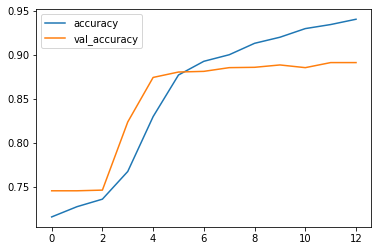

In [50]:
# Create Dataframe

history_df = pd.DataFrame(history.history)

# Plot between Accuracy and val_accuracy

history_df[['accuracy', 'val_accuracy']].plot()

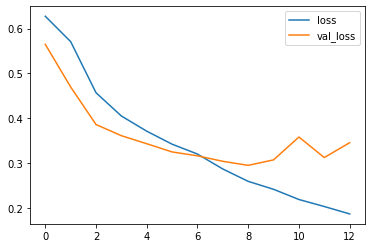

In [51]:
# Plot between loss and val_loss

history_df[['loss', 'val_loss']].plot()

In [52]:
# Model Evaluation using Classification Report

from sklearn.metrics import classification_report  

y_pred = model.predict(X_test)
y_pred= np.where(y_pred >= 0.5, 1, 0)
y_pred

print(classification_report(y_test, y_pred))

97/97 [==============================] - 5s 48ms/step
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       784
           1       0.91      0.96      0.93      2289

    accuracy                           0.90      3073
   macro avg       0.88      0.84      0.86      3073
weighted avg       0.89      0.90      0.89      3073



Bisa dilihat hasil evaluasi model menggunakan classification report:
* Untuk label 0 atau label `Bad`, model berhasil mendapatkan hasil yang cukup baik yaitu mendapatkan precision sebesar 0.86 dan recall sebesar 0.71. Hasil tersebut cukup baik dimana diketahui bahwa jumlah data label 0 atau label `Bad` hanya ada sedikit dibandingkan dengan label 1.
* Untuk label 1 atau label `Good`, model berhasil mendapatkan hasil yang sangat baik. Hal tersebut bisa dilihat dari hasil precision sebesar 0.91 dan recall sebesar 0.96.
* Dari classification report untuk model di atas berhasil mendapatkan overall accuracy sebesar 0.90 dimana angka tersebut lumayan tinggi.

# Model Inference

In [53]:
# Preprocessing inference

df_inf1['Review'] = df_inf1['Review'].apply(lambda x: clean_rev(x))

In [54]:
df_inf1

,Review,Rating,Length
0,fabulous sirenis tropicalpunta cana march onta...,Good,822
1,star price star product idyllic set gorgeous p...,Bad,866
2,great location mong kok great location explore...,Good,210
3,perfect london accomodation thoroughly enjoy s...,Good,571
4,unhelpful unfriendly staff hotel excellent loc...,Bad,436
5,overprice bland hotel usually stay old san jua...,Bad,440
6,b stay weekend boyfriend room ask save grace n...,Bad,437
7,good value money stay nights excelent location...,Bad,98
8,pleasant comfortable business mexico city stay...,Good,344
9,great hotel choose different location room lov...,Good,254


In [55]:
# Predict 

y_pred = model.predict(df_inf1.Review)
y_pred = np.where(y_pred >= 0.5, 1, 0)
y_pred

1/1 [==============================] - 0s 62ms/step


array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

In [56]:
# Transform back to the original category
y_pred1= le.inverse_transform(y_pred)

# Create DataFrame of Sentiment Prediction

pred_inf = pd.DataFrame(y_pred1, columns=['Sentiment Prediction'])

df_final = pd.concat([df_inf1, pred_inf], axis=1)

df_final

,Review,Rating,Length,Sentiment Prediction
0,fabulous sirenis tropicalpunta cana march onta...,Good,822,Good
1,star price star product idyllic set gorgeous p...,Bad,866,Bad
2,great location mong kok great location explore...,Good,210,Good
3,perfect london accomodation thoroughly enjoy s...,Good,571,Good
4,unhelpful unfriendly staff hotel excellent loc...,Bad,436,Bad
5,overprice bland hotel usually stay old san jua...,Bad,440,Bad
6,b stay weekend boyfriend room ask save grace n...,Bad,437,Good
7,good value money stay nights excelent location...,Bad,98,Good
8,pleasant comfortable business mexico city stay...,Good,344,Good
9,great hotel choose different location room lov...,Good,254,Good


Pada data inference, model berhasil mengklasifikasi 8 sentimen dari data secara tepat dari keseluruhan 10 data.

# Kesimpulan

Dataset kali ini berisikan data-data review pengguna aplikasi Trip Advisor terhadap hotel hotel yang ada di aplikasi tersebut. Dataset ini memiliki 2 kolom yaitu kolom review dan juga rating review. Dataset ini berisi data yang berjumlah sekitar 20 ribu data. Dari Exploratory Data Analysis, bisa didapatkan beberapa insight seperti :
* Rating paling banyak adalah rating 5 dengan jumlah rating lebih dari 9000. Lalu rating terbanyak kedua adalah rating 4 dengan jumlah lebih dari 6000 rating.
* Semakin tinggi peringkat hotel, semakin besar kemungkinan pengunjung menulis ulasan yang panjang.
* Jika rating review dibagi dua yaitu `Good` dan `Bad` dimana sentimen `Good` adalah rating 4-5 sedangkan sentimen `Bad` adalah rating 1-3 maka 73.7% Review memiliki sentimen `Good`, sedangkan 26.3% review lainnya memiliki sentimen `Bad`.
* Top 10 Token berdasarkan hasil text vectorization adalah hotel, room, not, stay, great, nt, good, staff.
* Top 10 words pada `Good` Review seperti hotel, room, stay, great, staff, good, night, time, dan location.
* Top 10 words pada `Bad` Review seperti hotel, room, stay, staff, good, night, time, day, dan service.
* Yang menjadi pembeda `Good` dan `Bad` adalah pada Bad Review banyak terdapat kata service. Kemungkinan banyak orang yang merasa servicenya kurang bagus.

Model yang dibuat untuk mengatasi kasus ini memiliki beberapa layer utama yaitu input layer, TextVectorization layer, Embedding layer, Bidirectional LSTM layer, dense layer, dan output layer.

Model tersebut berhasil mendapatkan hasil sebagai berikut :
* Untuk label 0 atau label `Bad`, model berhasil mendapatkan hasil yang cukup baik yaitu mendapatkan precision sebesar 0.86 dan recall sebesar 0.71. Hasil tersebut cukup baik dimana diketahui bahwa jumlah data label 0 atau label `Bad` hanya ada sedikit dibandingkan dengan label 1.
* Untuk label 1 atau label `Good`, model berhasil mendapatkan hasil yang sangat baik. Hal tersebut bisa dilihat dari hasil precision sebesar 0.91 dan recall sebesar 0.96.
* Dari classification report untuk model di atas berhasil mendapatkan overall accuracy sebesar 0.90 dimana angka tersebut lumayan tinggi.